In [55]:
# code to generate supplementary figures in `longitudinal_consistency` subfolder

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['font.family'] = 'Arial'

In [58]:
DATA_DIR = "../demo_data/"
MUTATIONS_FILE = "111e6e61e1_all_mutations.tsv"
SEG_CN_FILE = "best.seg.ucn"

INPUT_DIR = "../demo_inputs/"
MUT_CN_FILE = "111e6e61e1.decifer.input"
TREE_FILE = "111e6e61e1_stable.tree"

OUT_DIR = "../demo_outputs/"

In [59]:
# summary table for multi-region longitiudinal bulk sequenced samples from patient 4355
mutations_table = pd.read_csv(f"{DATA_DIR}{MUTATIONS_FILE}", sep="\t")
hatchet_table = pd.read_csv(f"{INPUT_DIR}{MUT_CN_FILE}", sep="\t")

In [60]:
# note: samples `7919980Met_FrTu_January_09_2020` and `7919980Met-2_FrTu_January_09_2020` were renamed to 
# `111e6e61e1Met_FrTu_January_09_2020` and `111e6e61e1Met-2_FrTu_January_09_2020`, respectively.

rename = {
    "7919980Met_FrTu_January_09_2020": "111e6e61e1Met_FrTu_January_09_2020",
    "7919980Met-2_FrTu_January_09_2020": "111e6e61e1Met-2_FrTu_January_09_2020"
}

mutations_table.DNA_sample_name = mutations_table.DNA_sample_name.apply(lambda x: rename[x] if x in rename.keys() else x)

In [61]:
samples = mutations_table.DNA_sample_name.unique()

samples

samples_namelookup = {}
samples_datelookup = {}

In [62]:
samples_treatpoint = {
    'February 2019': -212,
    'January 2020': 81,
    'August 2020': 342,
    'March 2021': 523,
    'July 2021': 523
}

In [63]:
for s in list(samples):
    #print(s)

    sample_info = s.split('_')
    
    samples_namelookup[s] = "_".join(sample_info[:-3])
    samples_datelookup[s] = f"{sample_info[-3]} {sample_info[-1]}"

In [64]:
tumour_purity = hatchet_table.set_index("sample")["normal_prop"] \
                             .drop_duplicates() \
                             .apply(lambda x: round(1-x,2)) \
                             .to_dict()

#tumour_purity

In [65]:
def get_summary(sample_name: str, hatchet_table):

    temp = mutations_table[mutations_table.DNA_sample_name == sample_name]
    temp = temp.drop_duplicates()

    # to out
    coverage = temp[["nreads_reference","nreads_variant"]].sum(axis=1).mean()
    coverage = int(round(coverage, 0))

    hatchet_table = hatchet_table[["mut_index","sample", "var_reads", "normal_state","tumor1_state", "tumor2_state"]]
    samplemuts = [m.replace(' ','_') for m in temp["Variant key"].tolist()]

    sample_hatchet = hatchet_table[(hatchet_table.mut_index.isin(samplemuts)) & (hatchet_table["sample"] == sample_name)  & (hatchet_table["var_reads"] > 0)]
    sample_hatchet = sample_hatchet.drop(["sample", "var_reads"],axis=1).set_index("mut_index")

    cn_neutral = sample_hatchet.applymap(lambda x: x=="1|1").sum(axis=1) == 3 

    a = len(sample_hatchet[cn_neutral].index.to_list())
    b = len(sample_hatchet[~cn_neutral].index.to_list())

    return coverage, a, b

In [66]:
table_entries = {}

for s in samples:

    coverage, a, b = get_summary(s, hatchet_table)
    name = samples_namelookup[s]
    date = samples_datelookup[s]
    tdate = samples_treatpoint[date]

    purity = tumour_purity[s]

    # print(name, coverage, a, b, purity, date, tdate)
    table_entries[name] = {
        'AVG. COVERAGE': coverage, 
        'MUTS (copy-number neutral)': a, 
        "MUTS (copy-number aberrant)": b, 
        "TUMOUR PURITY": purity, 
        "SAMPLING TIME POINTS": date,
        "PROGRESSION TIME POINT": tdate
    }
    

In [67]:
# sampling time points are given alongside relative to "progression time points" when clinical assessments were collected
out_table_1 = pd.DataFrame(table_entries).T
out_table_1 = out_table_1.sort_values(by=["PROGRESSION TIME POINT","SAMPLING TIME POINTS"], ascending=True)

#out_table_1.to_csv("/Users/wuchh/Downloads/sample_summary.tsv", sep="\t")
out_table_1.index.name = "SAMPLENAME"
out_table_1

,AVG. COVERAGE,MUTS (copy-number neutral),MUTS (copy-number aberrant),TUMOUR PURITY,SAMPLING TIME POINTS,PROGRESSION TIME POINT
SAMPLENAME,,,,,,
4355-AMet-Frag12_FrTu,220,287,122,0.61,February 2019,-212
4355-BMet-Frag24_FrTu,177,264,125,0.52,February 2019,-212
4355-AMet-Frag6_FrTu,211,282,125,0.67,February 2019,-212
111e6e61e1Met_FrTu,219,276,120,0.27,January 2020,81
111e6e61e1Met-2_FrTu,227,267,124,0.39,January 2020,81
4417-2BMet_FrTu,247,302,147,0.67,August 2020,342
4417-1AMet_FrTu,183,301,129,0.67,August 2020,342
4435Org-001-P9_Org,264,322,136,0.99,July 2021,523
4443Met-T1-2_FrTu,248,287,130,0.53,July 2021,523


In [68]:
dcf_table = pd.read_csv("/Users/wuchh/Documents/DETOPT/real_data/demo/demo_inputs/111e6e61e1_stable.inferred_freqs", sep="\t").set_index("cell_id_x_mut_id")

In [69]:
dcf_table = dcf_table[[
    '4355-AMet-Frag12_FrTu_February_04_2019',
    '4355-AMet-Frag6_FrTu_February_04_2019',
    '4355-BMet-Frag24_FrTu_February_04_2019',
    '111e6e61e1Met_FrTu_January_09_2020',
    '111e6e61e1Met-2_FrTu_January_09_2020', 
    '4417-2BMet_FrTu_August_04_2020',
    '4417-1AMet_FrTu_August_04_2020', 
    '4435-2Met_FrTu_March_03_2021',
    '4435-3Met_FrTu_March_03_2021', 
    '4435-1Met_FrTu_March_03_2021',
    '4435Org-001_Org_March_25_2021',
    '4435Org-001-P9_Org_July_23_2021',
    '4443Met-T1-4_FrTu_July_21_2021', 
    '4443Met-T1-5_FrTu_July_21_2021', 
    '4443Met-T1-2_FrTu_July_21_2021',
    '4443Met-T1-3_FrTu_July_21_2021', 
    '4443Met-T1-1_FrTu_July_21_2021', 
    '4443Met-T1-6_FrTu_July_21_2021'
]]

In [70]:
dcf_table.columns = ["_".join(i.split('_')[:2]) for i in dcf_table.columns]

In [71]:
dcf_index = [1,0,6,2,5,18,4,14,26,11,7,28,25,9,17,12,15,8,23,16,3,10,22,21,19,20,13,27,24]

In [72]:
dcf_table = dcf_table.reindex(dcf_index)

In [76]:
dcf_table.to_csv("/Users/wuchh/Downloads/111e6e61e1_dcf_table.tsv", sep="\t")

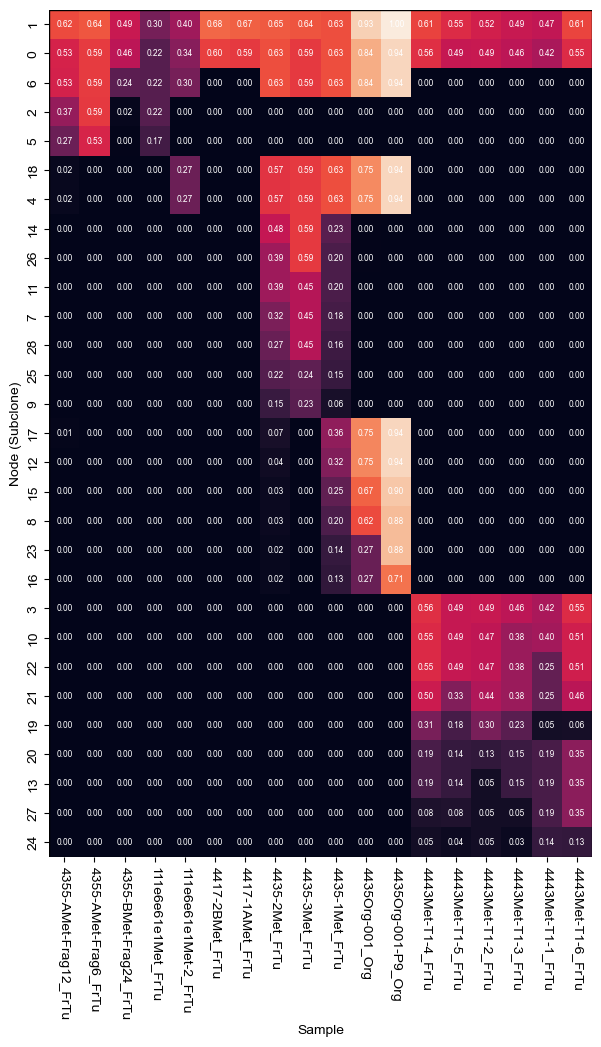

In [74]:
plt.figure(figsize=(7, 11))

sns.heatmap(dcf_table, cmap='rocket', vmin=0, vmax=1, cbar=False)

for i in range(len(dcf_table)):
    for j in range(len(dcf_table.columns)):
        plt.text(j + 0.5, i + 0.5, f'{"%.2f" % round(dcf_table.iloc[i, j], 2)}', ha='center', va='center', color='white', fontsize=6)

plt.gca().add_patch(plt.Rectangle((0,0),len(dcf_table.columns),len(dcf_table),linewidth=1,edgecolor='black',facecolor='none'))

plt.xticks(rotation=270)

#plt.title("111e6e61e1; Descendant Cell Fraction", fontweight='bold')
plt.xlabel("Sample")
plt.ylabel("Node (Subclone)")

plt.savefig(f"/Users/wuchh/Downloads/111e6e61e1_dcf.png", dpi=700, bbox_inches="tight")

In [ ]:
table2 = {}

for subclone, row in dcf_table.iterrows():

    samples_present = list(row[row > 0.05].index)

    samples = [samples_namelookup[i] for i in samples_present]
    dates = [samples_datelookup[i].split(' ')[-1] for i in samples_present]

    table2[subclone] = {
        'SUBCLONES PRESENT IN SAMPLES': ", ".join(samples),
        "TIME POINT SAMPLE OBTAINED (YEAR)": ", ".join(dates)
    }

table_2_out = pd.DataFrame(table2).T.reset_index()
table_2_out.columns = ['NODE_ID', 'SUBCLONES PRESENT IN SAMPLES', 'TIME POINT SAMPLE OBTAINED (YEAR)']
table_2_out.to_csv("/Users/wuchh/Downloads/sample_subclone_presence.tsv", sep="\t", index=False)

In [95]:
OUTFILE = "/Users/wuchh/Downloads/detopt-outfile2-4355.txt"

In [96]:
outfile = pd.read_csv(OUTFILE,sep="\t", header=None)
outfile.columns = ["MUT_ID", "NODE_ID", "A_iv", "B_iv", "A_v", "B_v"]

In [97]:
filt_muts = "10:71690272-71690272_G>-","11:34154645-34154645_C>-","12:112036777-112036782_TGCTGT>-","12:7045892-7045912_CAGCAGCAGCAGCAGCAGCAG>-","12:8377419-8377419_G>-","16:814979-814991_GCTCCCGAGGGGG>-","19:36002362-36002412_CTGCTGCCACCACTGCTGCCGCCACTGCTGCCGCCACTGCTGCTGCCACTG>-","19:45574993-45575007_GGCGGTTGAGCTTAC>-","19:7680191-7680210_GAGGGAGGAGGCCGCGAGGT>-","1:26608812-26608835_CCAGGACAGGGACTGGGGCCGGGA>-","22:21343966-21344002_GAGGAGGTGAGGGGCGTGGGGAGCCAGGGCGCAGGTA>-","2:20101537-20101537_C>-","6:30653494-30653496_TGC>-","6:90385898-90385898_C>-","7:151874148-151874148_T>-","19:1236047-1236049_GTG>-","19:4338664-4338666_CTT>-","20:1187656-1187656_C>-","17:38508282-38508282_A>-","17:7579359-7579359_G>-","11:12316387-12316389_CTA>-","1:12887218-12887218_->TGT","9:90746970-90746970_G>-","1:12887222-12887227_TGCTCT>-","19:50155362-50155367_CCGCTC>-","3:183493744-183493746_GGA>-","1:1684347-1684347_->CCT"

In [98]:
outfile = outfile[~outfile.MUT_ID.isin(filt_muts)]

In [99]:
len(outfile.MUT_ID.unique())

139

In [100]:
muts = outfile.MUT_ID.unique()

In [107]:
collector_iv = [0] * len(muts)
collector_v = [0] * len(muts)
collector_all = [0] * len(muts)

for i, mut in enumerate(muts):
    #print(mut)

    a = outfile[outfile.MUT_ID == mut]
    b = a.set_index("NODE_ID").drop("MUT_ID", axis=1)
    collector_iv[i] = b.iloc[:,:2].astype(str).agg(",".join, axis=1)
    collector_v[i] = b.iloc[:,2:].astype(str).agg(",".join, axis=1)
    collector_all[i] = b.astype(str).agg(",".join, axis=1)

In [108]:
outtable = pd.concat(collector_iv, axis=1)
outtable.columns = muts

In [109]:
outtable.T.to_csv("/Users/wuchh/Downloads/mutant_copies_A_B.tsv", sep="\t")

In [110]:
outtable2 = pd.concat(collector_v, axis=1)
outtable2.columns = muts

In [111]:
outtable2.T.to_csv("/Users/wuchh/Downloads/all_copies_A_B.tsv", sep="\t")

In [112]:
outtable3 = pd.concat(collector_all, axis=1)
outtable3.columns = muts

outtable3.T.to_csv("/Users/wuchh/Downloads/A_iv_B_iv_A_v_B_v.tsv", sep="\t")